# **OSA Case Study**
**Iván Alba Elhazaz**

**Ángela Esteban**

# Table of contents
1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

# Introduction

This notebook processes and analyses the provided database `Info_BDApnea_QuironMalaga.xlsx`. In order to execute the notebook, make sure that the file is loaded onto the working space.

In [ ]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, shapiro, levene

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier
)

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


In [ ]:
excel_file = 'Info_BDApnea_QuironMalaga.xlsx'
df = pd.read_excel(excel_file)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient         685 non-null    object 
 1   Comentarios     857 non-null    object 
 2   Audios tumbado  683 non-null    object 
 3   Fotos           683 non-null    object 
 4   Audio fs KHz    683 non-null    object 
 5   Gender          683 non-null    object 
 6   EPWORTH         55 non-null     object 
 7   IAH             649 non-null    float64
 8   IAH Supino      589 non-null    object 
 9   IAH Lateral     526 non-null    object 
 10  Peso            678 non-null    object 
 11  Talla           677 non-null    float64
 12  IMC             678 non-null    float64
 13  Edad            678 non-null    float64
 14  PerCervical     678 non-null    float64
 15  Fumador         680 non-null    object 
 16  Roncador        680 non-null    object 
 17  Enfermedades    678 non-null    obj

Based on a preliminary analysis of the given dataset, this notebook will work with a subset of the initial dataset given by the columns selected in the next section. Albeit, other variables of the initial dataset may be taken into account for posterior analysis.

In [ ]:
# df_core will define a subset of the initial dataframe
df_core = df[['Gender', 'Peso', 'Talla', 'Edad', 'PerCervical', 'IAH']].copy()
# The column names are renamed to english
df_core = df_core.rename(columns={
    'Peso': 'Weight',
    'Talla': 'Height',
    'Edad': 'Age',
    'PerCervical': 'NeckCirc'
})
# Display the info of the subset database
df_core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gender    683 non-null    object 
 1   Weight    678 non-null    object 
 2   Height    677 non-null    float64
 3   Age       678 non-null    float64
 4   NeckCirc  678 non-null    float64
 5   IAH       649 non-null    float64
dtypes: float64(4), object(2)
memory usage: 41.1+ KB


# Data Preparation

##Table of contents
1.  [Initial observations](###Initial-observations)
2.  [Imputations and discarded samples](###Imputations-and-discarded-samples)
3.  [Extended dataset](###Extended-dataset)

###Initial observations

Firstly, the next cell will one-hot encode the gender column into a binary variable where 0 is 'male' and 1 is 'female'.

In [ ]:
gender_mapping = {'hombre': 0, 'mujer': 1}
df_core['Gender'] = df_core['Gender'].map(gender_mapping)

We can see from `df_core.info()` that the Weight is an object, mainly due to annotations like 'Does not want to know' in that column, making the columns datatype not interpreted as numeric. Also, Height, Age, NeckCirc and IAH contain values like -1 and 0 instead of NaNs. The following cell swaps features like 'Does not want to know', 0, or -1 for NaN values for posterior analysis.

In [ ]:
for col in ['Gender', 'Weight', 'Height', 'NeckCirc', 'Age']:
    df_core[col] = pd.to_numeric(df_core[col], errors='coerce')

df_core[['Weight', 'Height', 'NeckCirc', 'Age']] = df_core[['Weight', 'Height', 'NeckCirc', 'Age']].replace([-1, 0], np.nan)

In [ ]:
df_core.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gender    683 non-null    float64
 1   Weight    675 non-null    float64
 2   Height    676 non-null    float64
 3   Age       675 non-null    float64
 4   NeckCirc  671 non-null    float64
 5   IAH       649 non-null    float64
dtypes: float64(6)
memory usage: 41.1 KB


As we can see, we now have more null values than before due to the replacement of invalid values with NaN values.

In the following cell, we represent the number of missing features per record/sample. We will see that many samples are fully empty or mostly empty. The point of these next few cells is to drop those samples from the dataset.

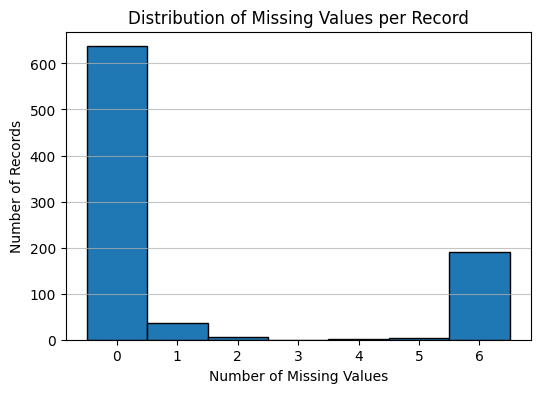

In [ ]:
h=df_core.isna().sum(axis=1);
plt.figure(figsize=(6, 4))
plt.hist(h, bins=np.arange(h.min(), h.max() + 2) - 0.5, edgecolor='black')
plt.title('Distribution of Missing Values per Record'); plt.xlabel('Number of Missing Values'); plt.ylabel('Number of Records'); plt.xticks(np.arange(h.min(), h.max() + 1)); plt.grid(axis='y', alpha=0.75)
plt.show()

As we can see almost a third of the dataset has too many missing values to consider. We will consider that records with 3 or more missing values are invalid, so we will drop them from the dataset.

In [ ]:
df_core.shape

(873, 6)

In [ ]:
df_core['missing_count'] = df_core.isna().sum(axis=1)
df_core = df_core[df_core['missing_count'] <= 2]
df_core=df_core.drop(columns=['missing_count'])

In [ ]:
df_core.shape

(678, 6)

Notice that we have dropped almost 200 samples.

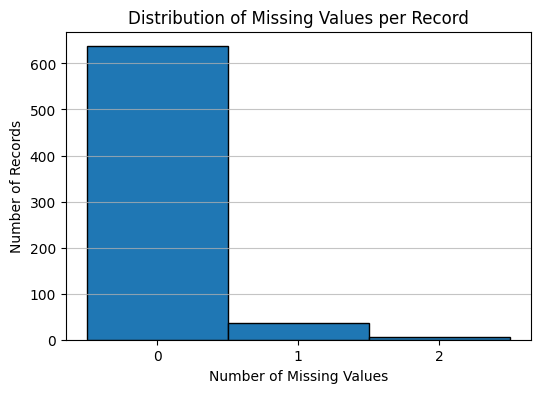

In [ ]:
h=df_core.isna().sum(axis=1);
plt.figure(figsize=(6, 4))
plt.hist(h, bins=np.arange(h.min(), h.max() + 2) - 0.5, edgecolor='black')
plt.title('Distribution of Missing Values per Record'); plt.xlabel('Number of Missing Values'); plt.ylabel('Number of Records'); plt.xticks(np.arange(h.min(), h.max() + 1)); plt.grid(axis='y', alpha=0.75)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
df_core.isna().sum()

,0
Gender,0
Weight,3
Height,2
Age,3
NeckCirc,7
IAH,31


###Imputations and discarded samples

When performing a regression task on a target variable like `IAH` in this case. Performing imputation does not make sense and considering only the non-target variables of the sample is only useful for some unsupervised feature analysis like PCA. Given that the number of samples with a missing IAH is considerably lower than the size of the database and the problems that imputing this value may pose, it is sensible to drop all the samples without an `IAH` value.




In [ ]:
df_core = df_core.dropna(subset=['IAH'])

We impute the rest of the values with the median value

In [ ]:
for col in ['Weight', 'Height', 'NeckCirc', 'Age']:
    df_core[col] = df_core[col].fillna(df_core[col].median())

For analysis purposes we will add a `Height_squared` column and we will also compute the `BMI` of the patient considering the `Weight` and `Height_squared` columns.

In [ ]:
df_core['Height_squared'] = df_core['Height']**2
df_core['BMI'] = df_core['Weight'] / (df_core['Height_squared']) * 10000

Finally, our dataset is the following

In [ ]:
ordered_core_cols = ['Gender', 'Age', 'Weight', 'Height', 'Height_squared', 'BMI', 'NeckCirc', 'IAH']
df_core=df_core[ordered_core_cols]
df_core.head()

,Gender,Age,Weight,Height,Height_squared,BMI,NeckCirc,IAH
0,0.0,39.0,82.0,168.0,28224.0,29.053288,41.0,71.0
1,0.0,56.0,119.0,174.0,30276.0,39.305060,48.0,29.6
2,0.0,46.0,86.0,171.0,29241.0,29.410759,43.0,56.0
3,0.0,39.0,78.0,168.0,28224.0,27.636054,42.0,19.7
4,0.0,32.0,80.0,173.0,29929.0,26.729927,40.0,9.0


In [ ]:
len(df_core)

647

In [ ]:
df_core.to_excel("OSA_clean_dataset.xlsx", index=False)

###Extended dataset

Next, an extended version of the dataset is considered, with variables `Snoring` and `Smoker`.

In [ ]:
df_extended = df_core.copy()
df_extended['Snoring'] = df.loc[df_extended.index, 'Roncador']
df_extended["Snoring"].value_counts(dropna=False)

,count
Snoring,
si,435
ns,177
no,17
CPAP,11
no con CPAD,4
poco,1
si´(protesis boca para dormir),1
si sin CPAP,1


As we can see `Snoring` has many different text entries and is hard to analyze.

In [ ]:
df_extended['Smoker'] = df.loc[df_extended.index, 'Fumador']
df_extended["Smoker"].value_counts(dropna=False)

,count
Smoker,
no,355
si,156
antiguo,113
ns,16
poco,6
si (poco),1


The same happens with `Smoker`.

Both of these variables contain a lot of NaN values, even considering only the clean dataset. This means that if we want to consider them we have to perfom imputation in a lot of the samples. We will consider that the NaN values correspond to a third category 'does not know' because both features present the categories 'yes', 'no' and 'does not know' written in some way or another. The mapping from strings to these categories is done in the following cell.


In [ ]:
mapping_roncador = {
    "si": 1, "si sin CPAP": 1, "si´(protesis boca para dormir)": 1, "CPAP": 1,
    "no": 0, "no con CPAP": 0, "no con CPAD": 0,
    "poco":2, "ns": 2
}

mapping_fumador = {
    "no": 0,
    "si": 1, "si (poco)": 1,
    "antiguo": 2,
    "poco": 2, "ns": 2
}

df_extended['Smoker'] = df_extended['Smoker'].replace(mapping_fumador)
df_extended['Snoring'] = df_extended['Snoring'].replace(mapping_roncador)

/tmp/ipython-input-1633086982.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_extended['Smoker'] = df_extended['Smoker'].replace(mapping_fumador)
/tmp/ipython-input-1633086982.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_extended['Snoring'] = df_extended['Snoring'].replace(mapping_roncador)


Where the categories are mapped the following way:

*   1 -> Yes
*   0 -> No
*   2 -> Dont know



In [ ]:
df_extended[['Smoker', 'Snoring']].isna().sum()

,0
Smoker,0
Snoring,0


Therefore we have the second dataset OSA `OSA_extended_dataset.xlsx`


In [ ]:
df_extended=df_extended[['Gender', 'Age', 'Weight', 'Height', 'Height_squared', 'BMI', 'NeckCirc', 'Snoring', 'Smoker', 'IAH']]
df_extended.head()

,Gender,Age,Weight,Height,Height_squared,BMI,NeckCirc,Snoring,Smoker,IAH
0,0.0,39.0,82.0,168.0,28224.0,29.053288,41.0,2,2,71.0
1,0.0,56.0,119.0,174.0,30276.0,39.305060,48.0,2,1,29.6
2,0.0,46.0,86.0,171.0,29241.0,29.410759,43.0,2,1,56.0
3,0.0,39.0,78.0,168.0,28224.0,27.636054,42.0,2,0,19.7
4,0.0,32.0,80.0,173.0,29929.0,26.729927,40.0,2,0,9.0


In [ ]:
df_extended.to_excel("OSA_extended_dataset.xlsx", index=False)

# Exploratory Data Analysis

## Table of contents

1. [Univariate Analysis](###Univariate-Analysis)
2. [Bivariate Analysis](###Bivariate-Analysis)
3. [Multivariate Analysis](###Multivariate-Analysis)


The dataset `OSA_clean_dataset.xlsx` and `OSA_extended_dataset.xlsx` will be needed for this section.

###UnivariateAnalysis

*  **IAH**





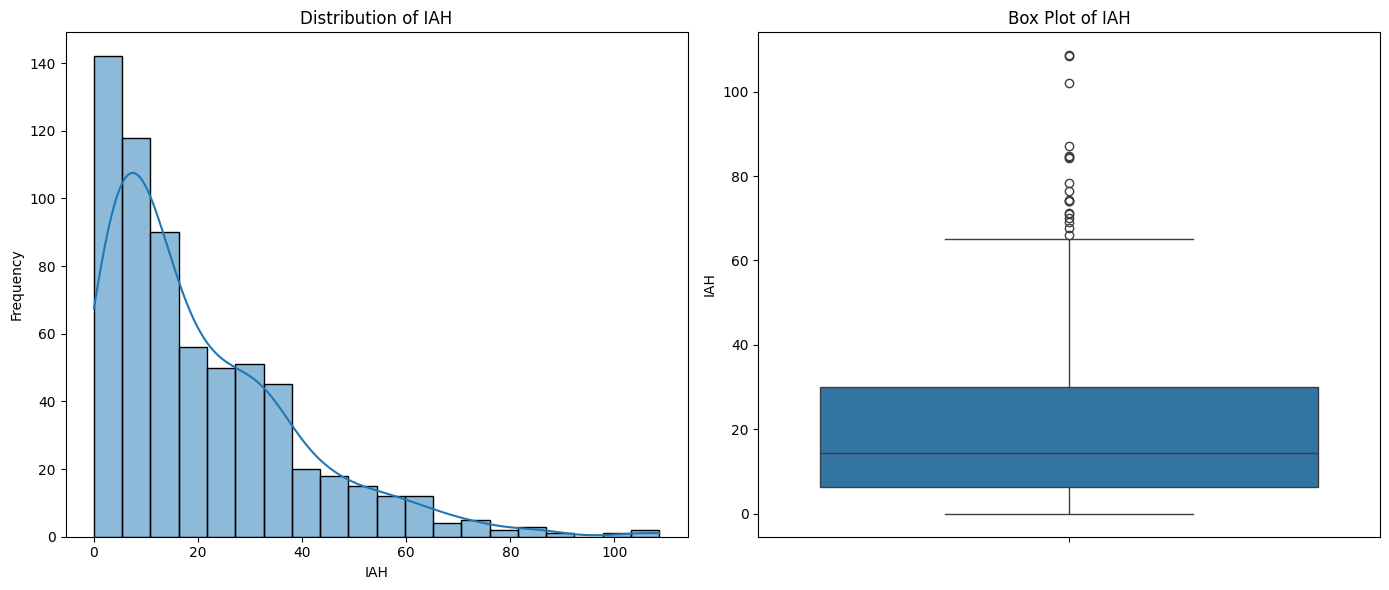


Descriptive statistics for the 'IAH' column:
count    647.000000
mean      20.424049
std       18.691050
min        0.000000
25%        6.350000
50%       14.300000
75%       30.000000
max      108.600000
Name: IAH, dtype: float64


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of IAH
sns.histplot(df_core['IAH'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of IAH')
axes[0].set_xlabel('IAH')
axes[0].set_ylabel('Frequency')

# Box plot of IAH
sns.boxplot(y=df_core['IAH'], ax=axes[1])
axes[1].set_title('Box Plot of IAH')
axes[1].set_ylabel('IAH')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for the 'IAH' column:")
print(df_core['IAH'].describe())

*  **Predictors from the core dataset**


In [ ]:

mapa={0:'Male', 1:'Female'}
df_core['Gender_label'] = df_core['Gender'].map(mapa)

In [ ]:
mapa[1]

'Female'

Performing univariate analysis for numerical features (excluding 'IAH'):

Analyzing column: Age


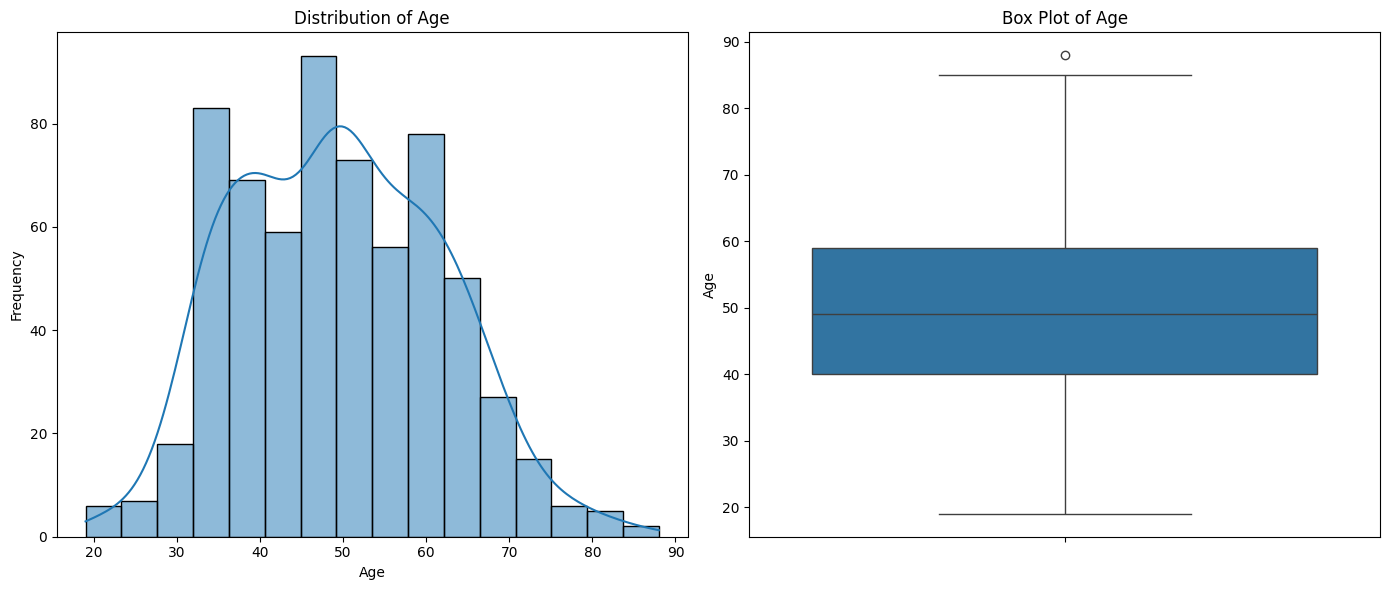


Descriptive statistics for 'Age':
count    647.000000
mean      49.426584
std       12.411436
min       19.000000
25%       40.000000
50%       49.000000
75%       59.000000
max       88.000000
Name: Age, dtype: float64

Shapiro–Wilk test for 'Age' | Gender=0.0
Statistic = 0.9831, p-value = 3.2969e-05
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'Age' | Gender=1.0
Statistic = 0.9862, p-value = 6.7325e-02
→ Fail to reject H₀: normality assumed.

Levene test for equality of variances (by Gender):
Statistic = 0.5273, p-value = 4.6799e-01
→ Fail to reject H₀: variances CAN be assumed equal.


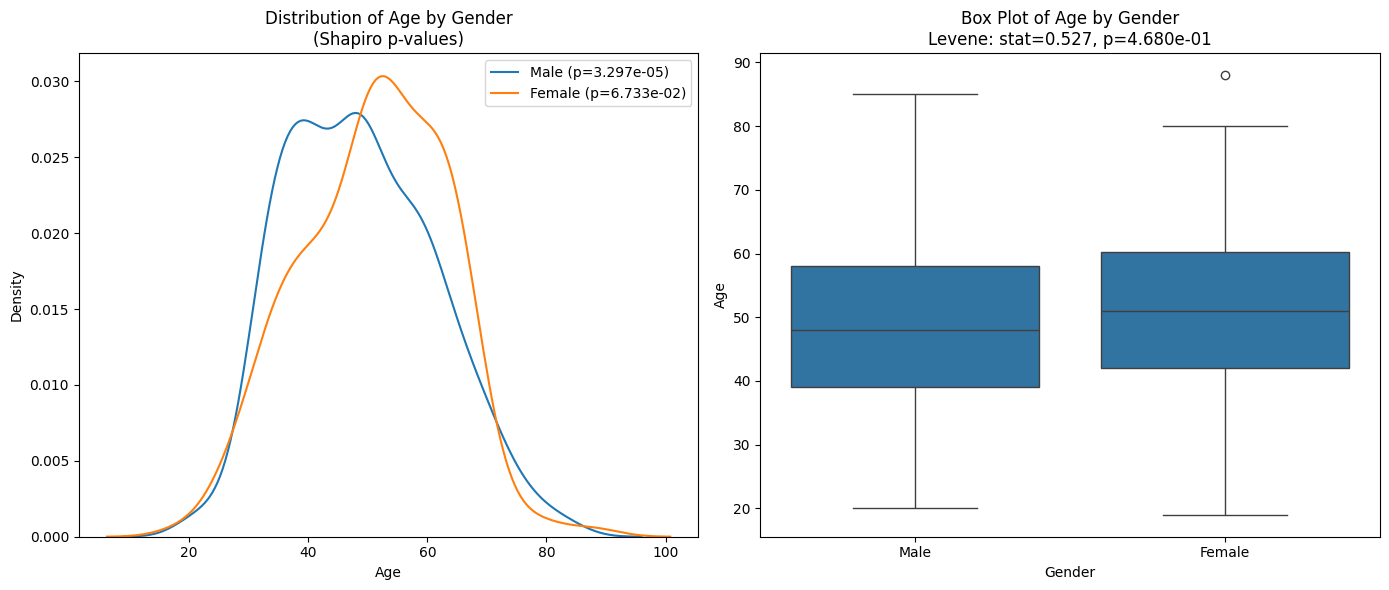


------------------------------------------------------------

Analyzing column: Weight


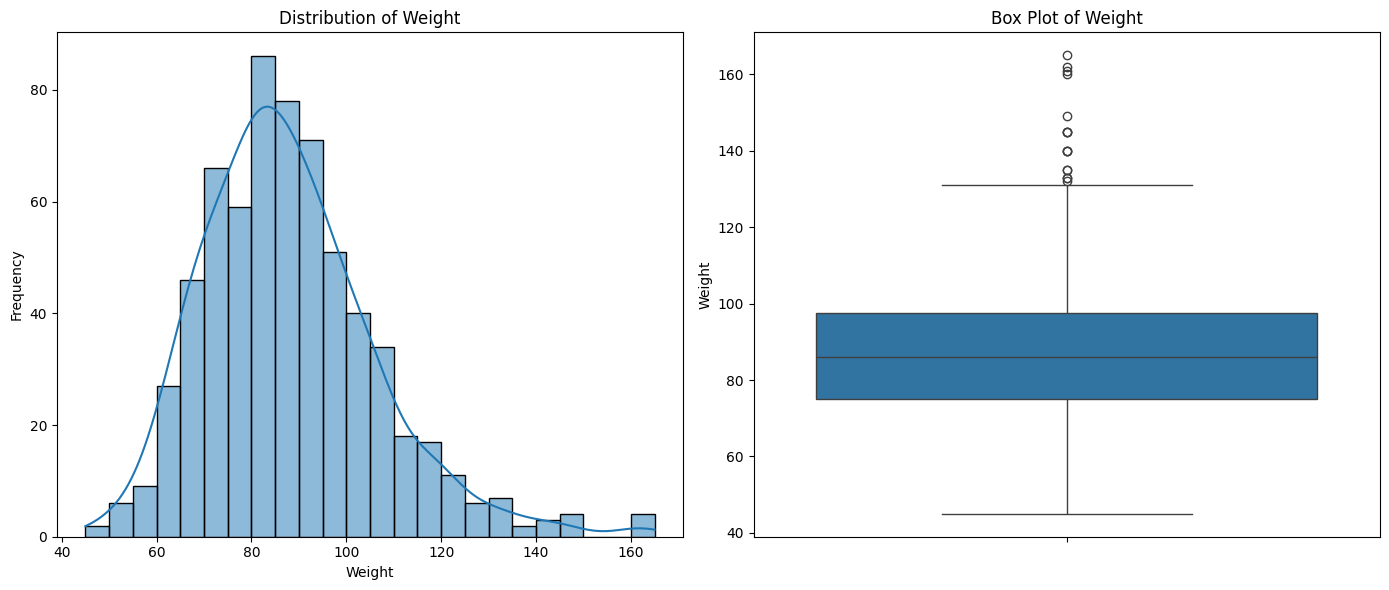


Descriptive statistics for 'Weight':
count    647.000000
mean      87.675425
std       18.259814
min       45.000000
25%       75.000000
50%       86.000000
75%       97.500000
max      165.000000
Name: Weight, dtype: float64

Shapiro–Wilk test for 'Weight' | Gender=0.0
Statistic = 0.9329, p-value = 1.4416e-13
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'Weight' | Gender=1.0
Statistic = 0.9318, p-value = 1.3110e-07
→ Reject H₀: normality NOT assumed.

Levene test for equality of variances (by Gender):
Statistic = 0.3450, p-value = 5.5715e-01
→ Fail to reject H₀: variances CAN be assumed equal.


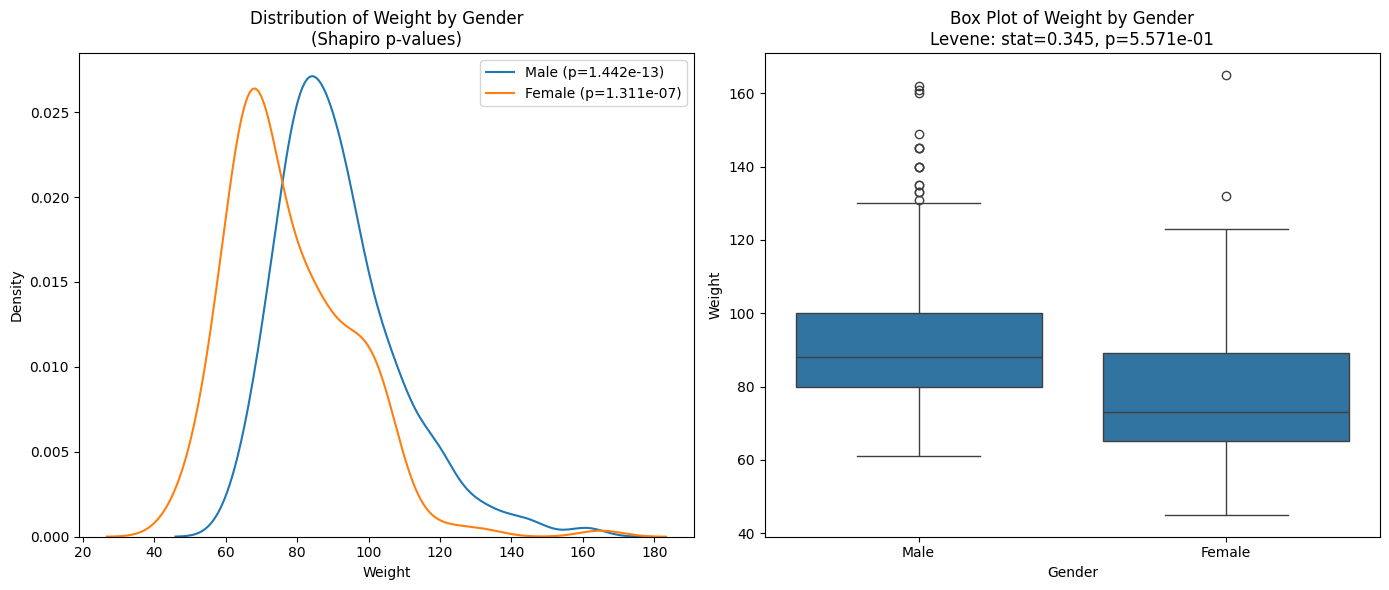


------------------------------------------------------------

Analyzing column: Height


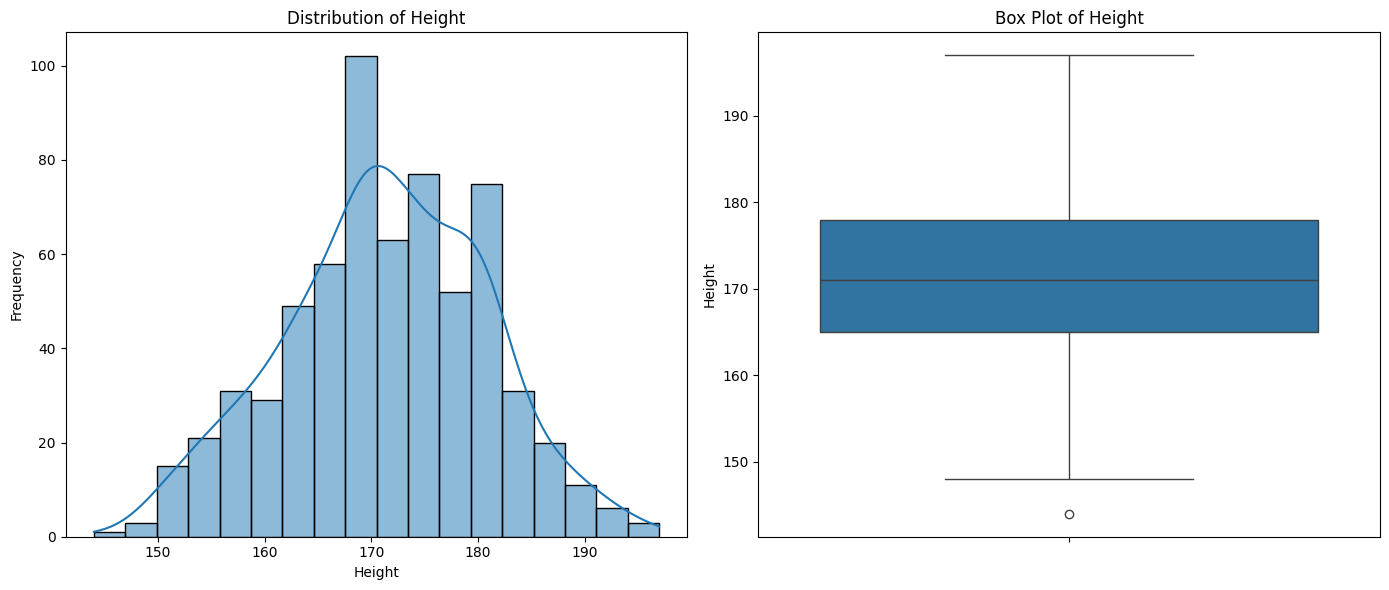


Descriptive statistics for 'Height':
count    647.000000
mean     171.313756
std        9.511546
min      144.000000
25%      165.000000
50%      171.000000
75%      178.000000
max      197.000000
Name: Height, dtype: float64

Shapiro–Wilk test for 'Height' | Gender=0.0
Statistic = 0.9919, p-value = 1.2738e-02
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'Height' | Gender=1.0
Statistic = 0.9897, p-value = 2.0841e-01
→ Fail to reject H₀: normality assumed.

Levene test for equality of variances (by Gender):
Statistic = 2.4885, p-value = 1.1517e-01
→ Fail to reject H₀: variances CAN be assumed equal.


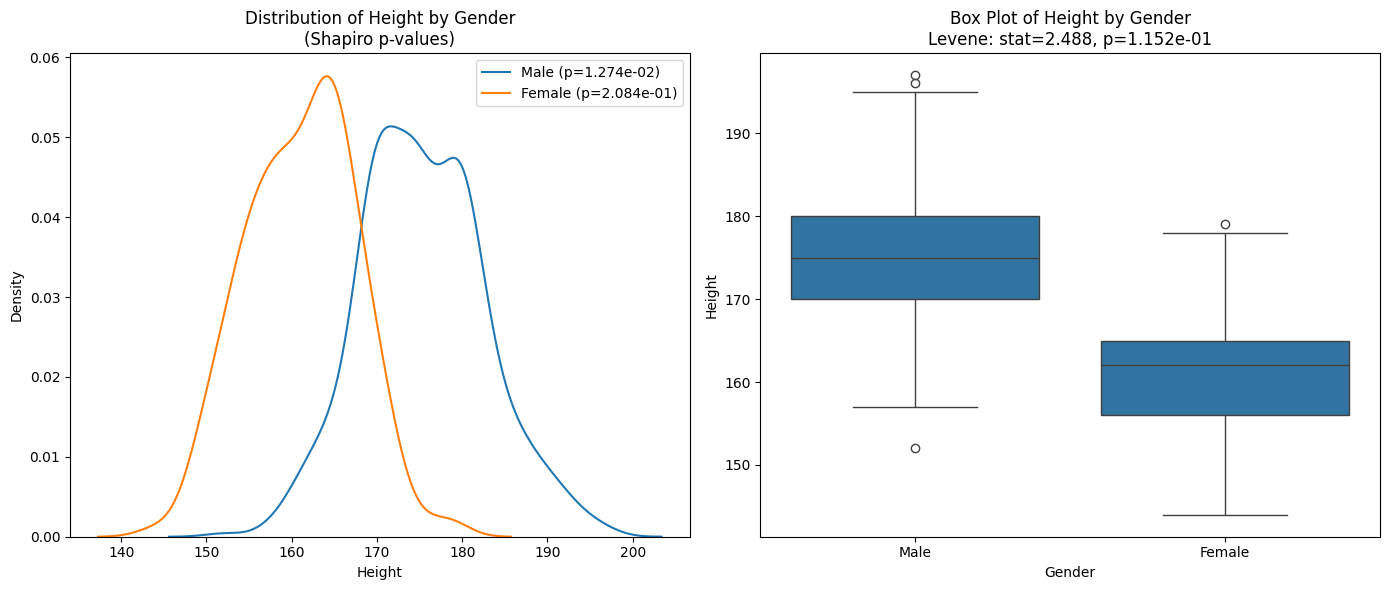


------------------------------------------------------------

Analyzing column: Height_squared


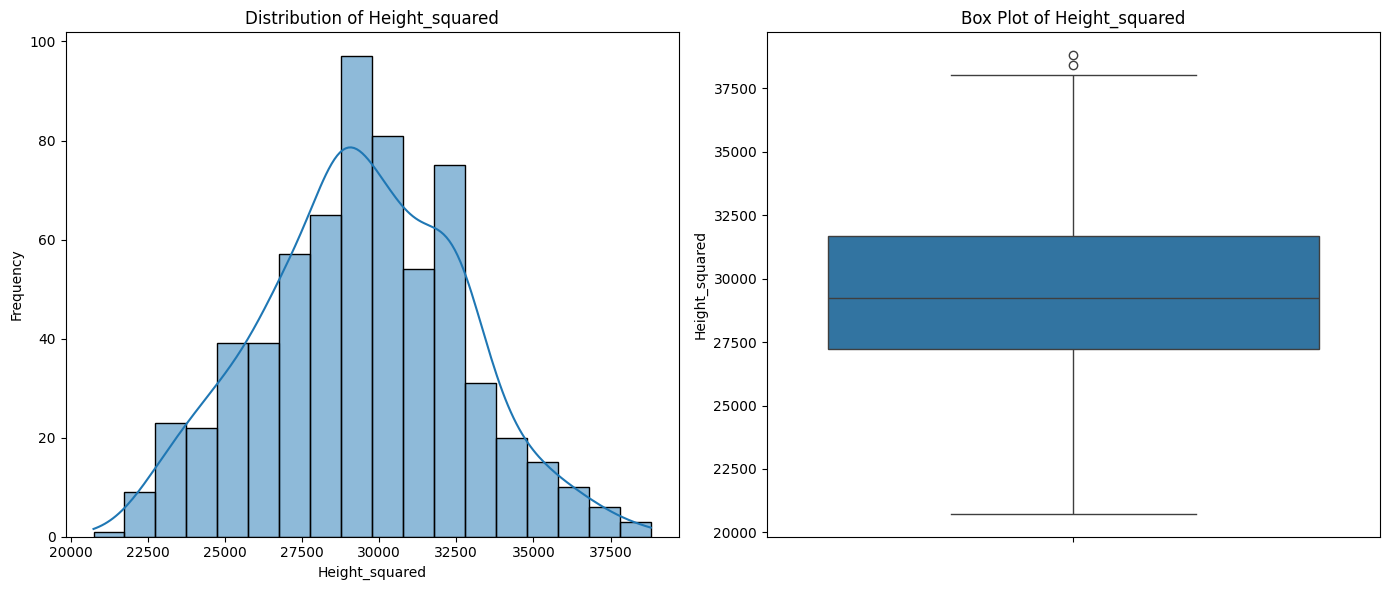


Descriptive statistics for 'Height_squared':
count      647.000000
mean     29438.732612
std       3250.569095
min      20736.000000
25%      27225.000000
50%      29241.000000
75%      31684.000000
max      38809.000000
Name: Height_squared, dtype: float64

Shapiro–Wilk test for 'Height_squared' | Gender=0.0
Statistic = 0.9886, p-value = 1.1508e-03
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'Height_squared' | Gender=1.0
Statistic = 0.9895, p-value = 1.9148e-01
→ Fail to reject H₀: normality assumed.

Levene test for equality of variances (by Gender):
Statistic = 7.8074, p-value = 5.3577e-03
→ Reject H₀: variances CANNOT be assumed equal.


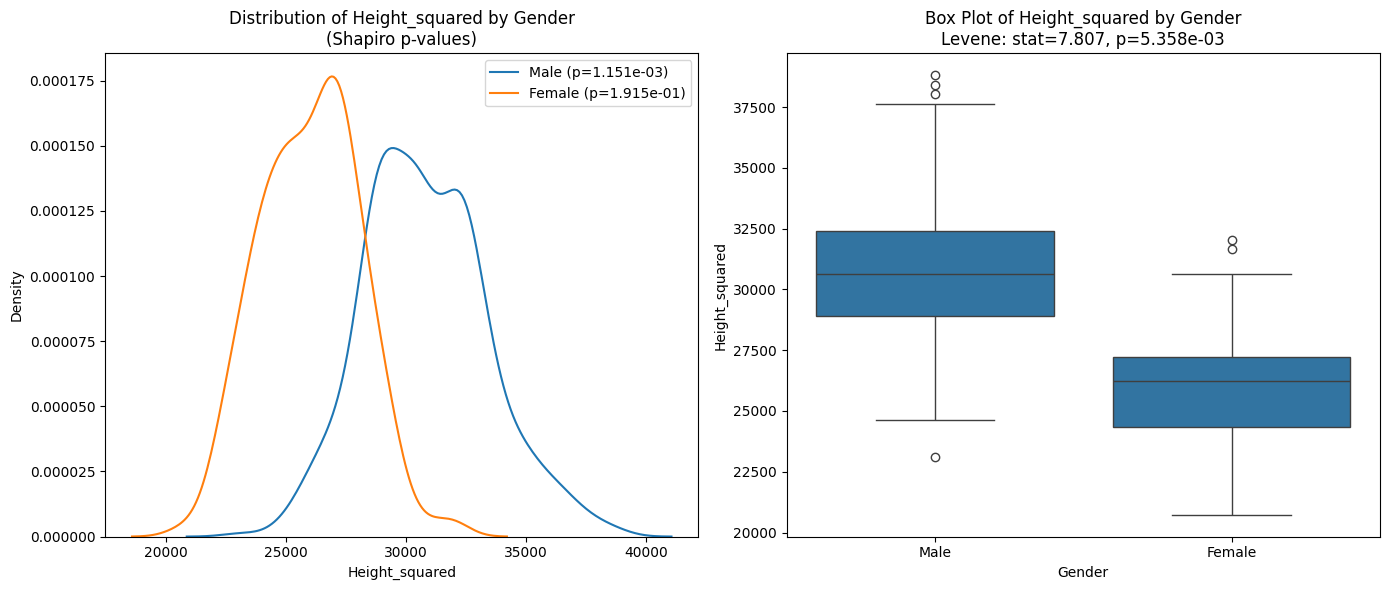


------------------------------------------------------------

Analyzing column: BMI


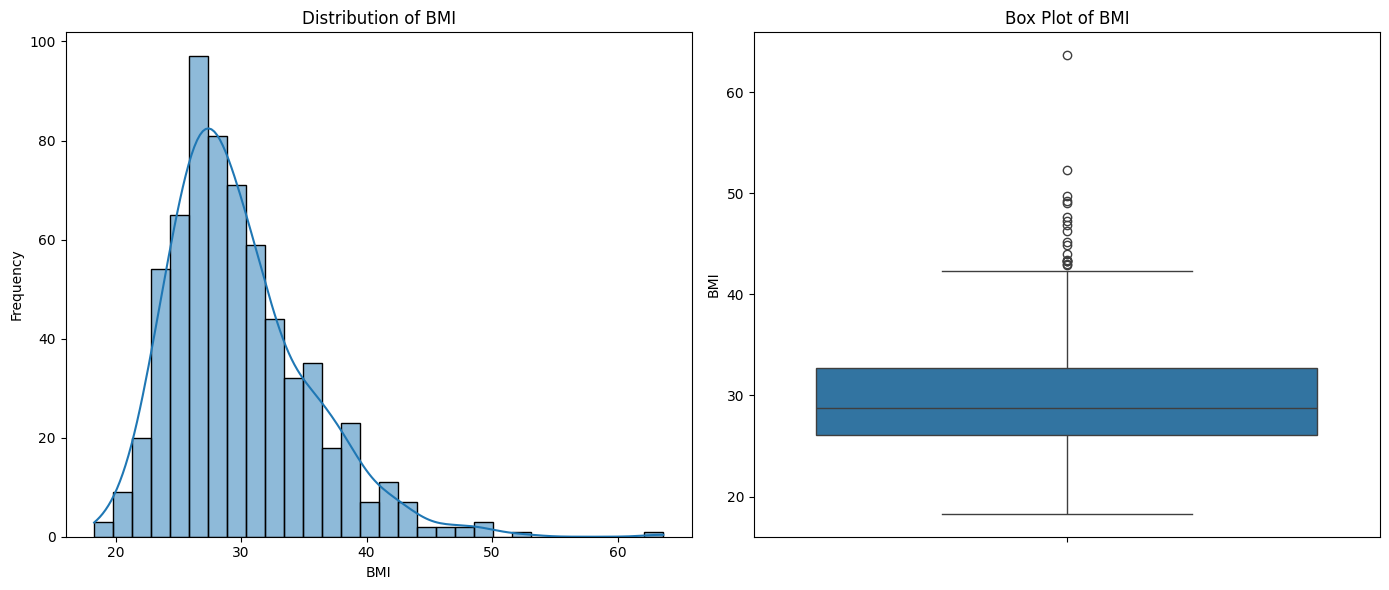


Descriptive statistics for 'BMI':
count    647.000000
mean      29.833682
std        5.588526
min       18.289895
25%       26.038138
50%       28.731747
75%       32.671802
max       63.654952
Name: BMI, dtype: float64

Shapiro–Wilk test for 'BMI' | Gender=0.0
Statistic = 0.9342, p-value = 2.0242e-13
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'BMI' | Gender=1.0
Statistic = 0.9378, p-value = 3.9722e-07
→ Reject H₀: normality NOT assumed.

Levene test for equality of variances (by Gender):
Statistic = 17.9695, p-value = 2.5727e-05
→ Reject H₀: variances CANNOT be assumed equal.


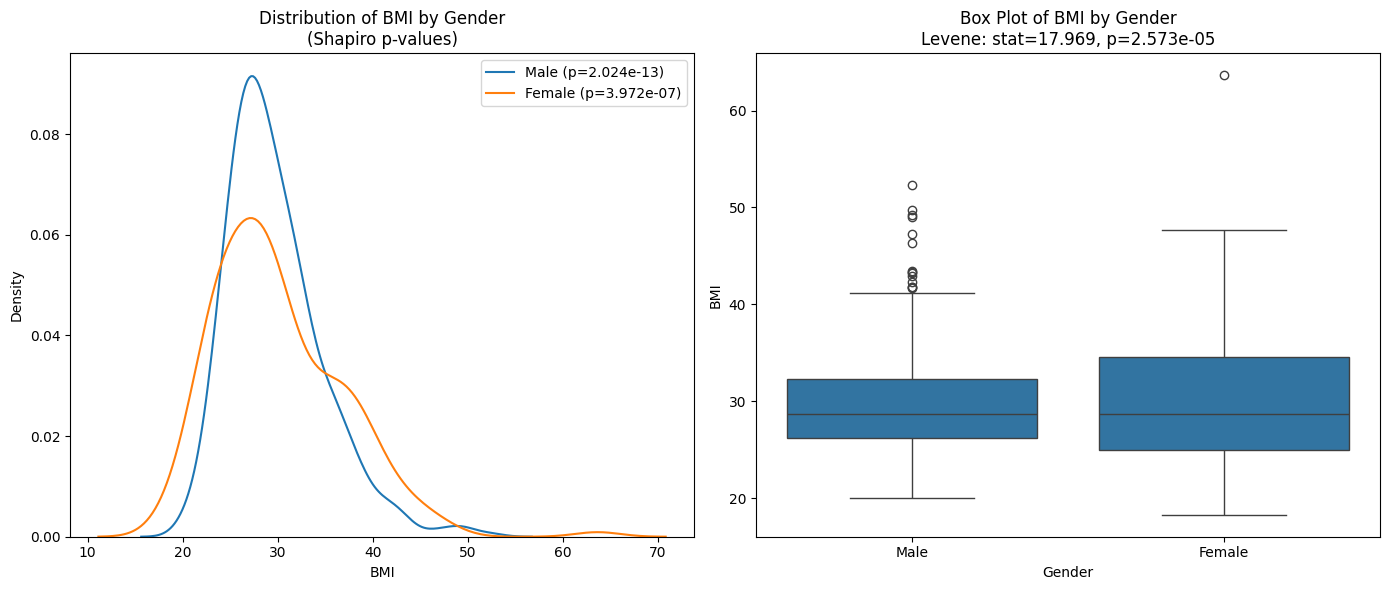


------------------------------------------------------------

Analyzing column: NeckCirc


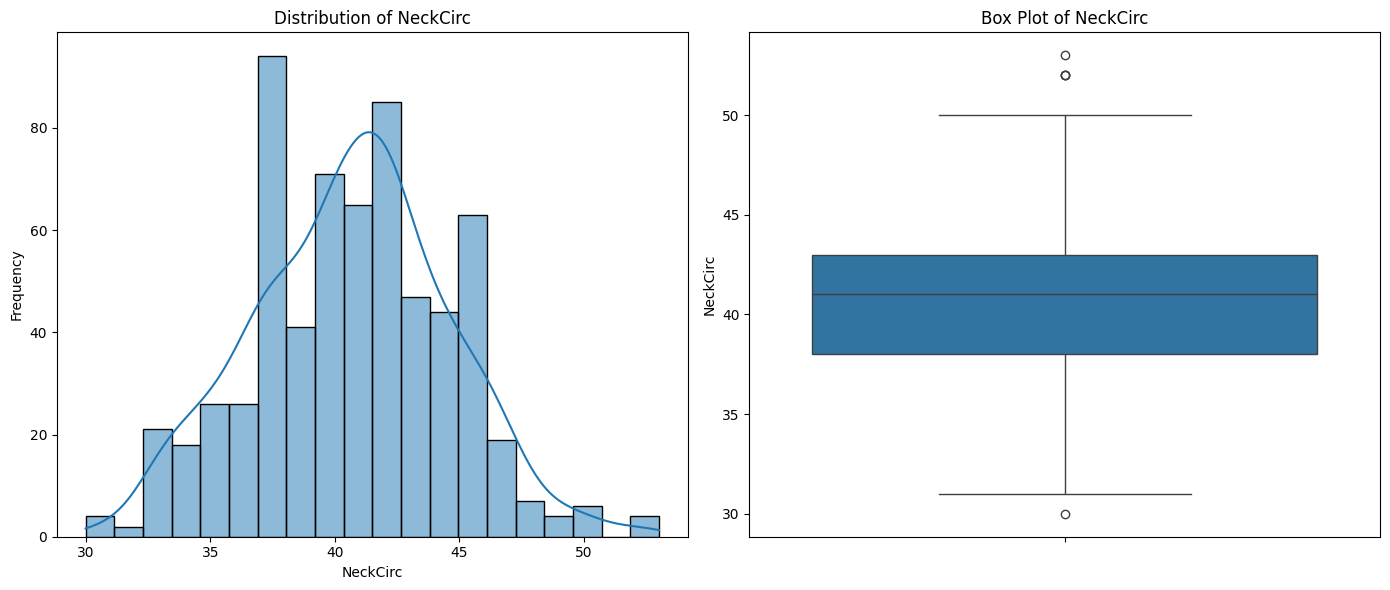


Descriptive statistics for 'NeckCirc':
count    647.000000
mean      40.640649
std        3.928679
min       30.000000
25%       38.000000
50%       41.000000
75%       43.000000
max       53.000000
Name: NeckCirc, dtype: float64

Shapiro–Wilk test for 'NeckCirc' | Gender=0.0
Statistic = 0.9819, p-value = 1.6246e-05
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'NeckCirc' | Gender=1.0
Statistic = 0.9759, p-value = 2.8058e-03
→ Reject H₀: normality NOT assumed.

Levene test for equality of variances (by Gender):
Statistic = 0.1816, p-value = 6.7010e-01
→ Fail to reject H₀: variances CAN be assumed equal.


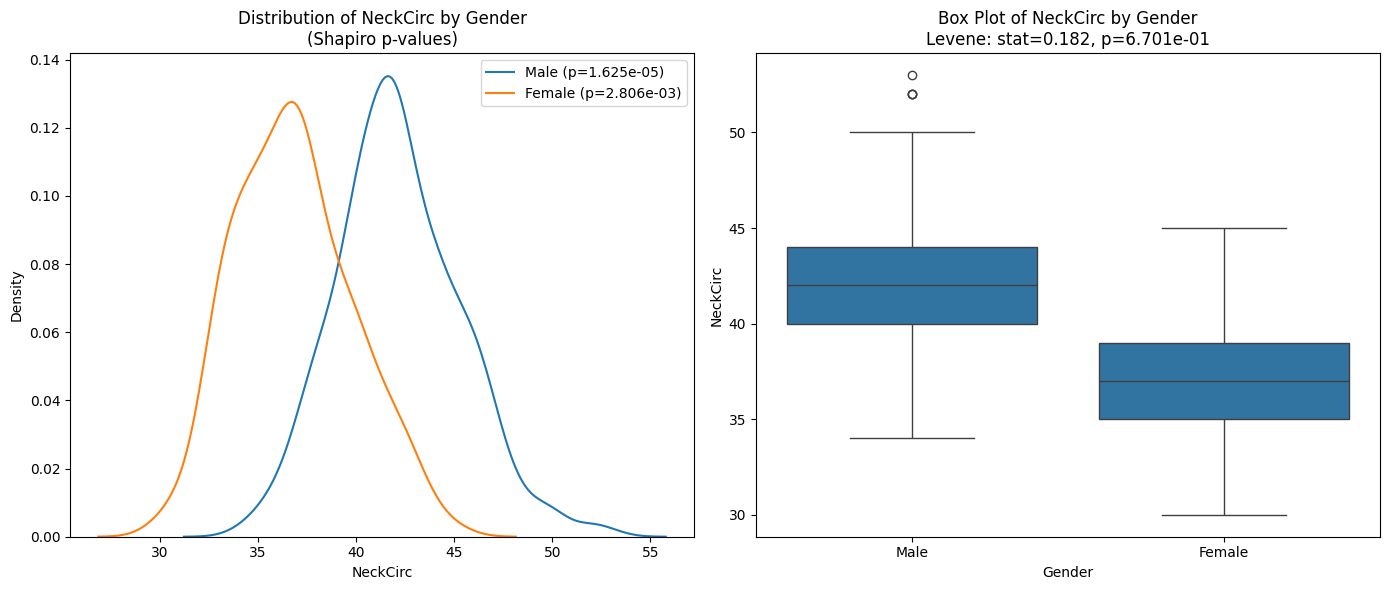


------------------------------------------------------------

Analyzing column: IAH


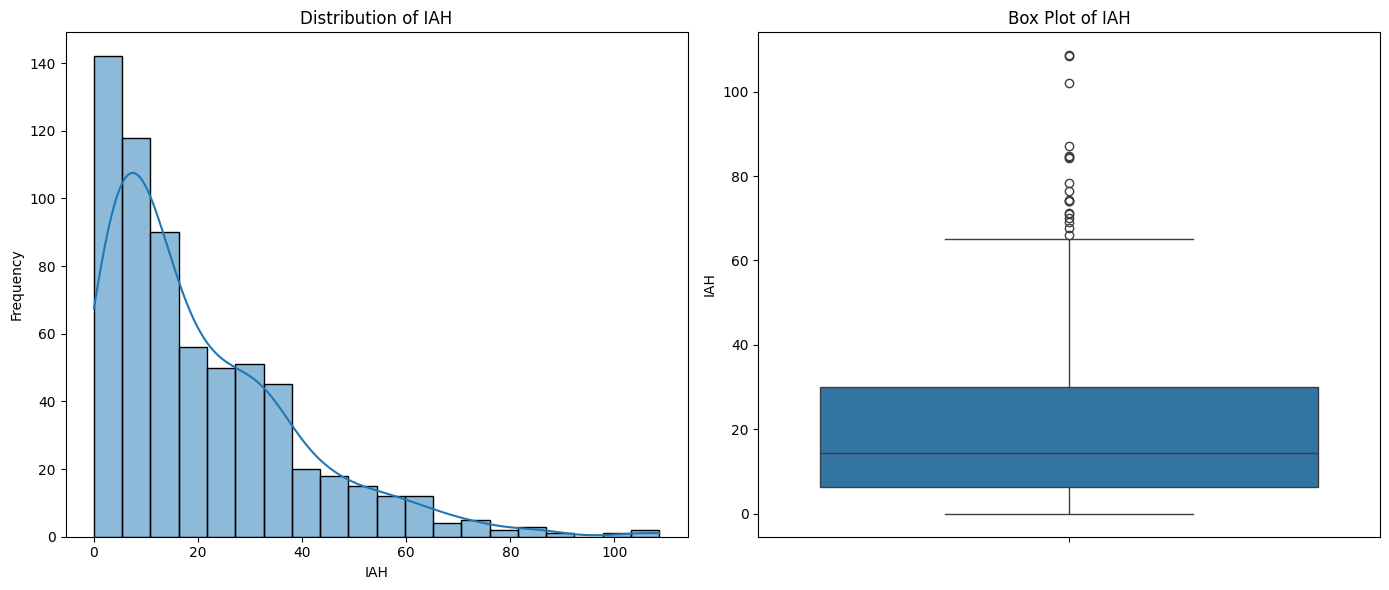


Descriptive statistics for 'IAH':
count    647.000000
mean      20.424049
std       18.691050
min        0.000000
25%        6.350000
50%       14.300000
75%       30.000000
max      108.600000
Name: IAH, dtype: float64

Shapiro–Wilk test for 'IAH' | Gender=0.0
Statistic = 0.9048, p-value = 2.0031e-16
→ Reject H₀: normality NOT assumed.

Shapiro–Wilk test for 'IAH' | Gender=1.0
Statistic = 0.7291, p-value = 4.8199e-17
→ Reject H₀: normality NOT assumed.

Levene test for equality of variances (by Gender):
Statistic = 7.2690, p-value = 7.1987e-03
→ Reject H₀: variances CANNOT be assumed equal.


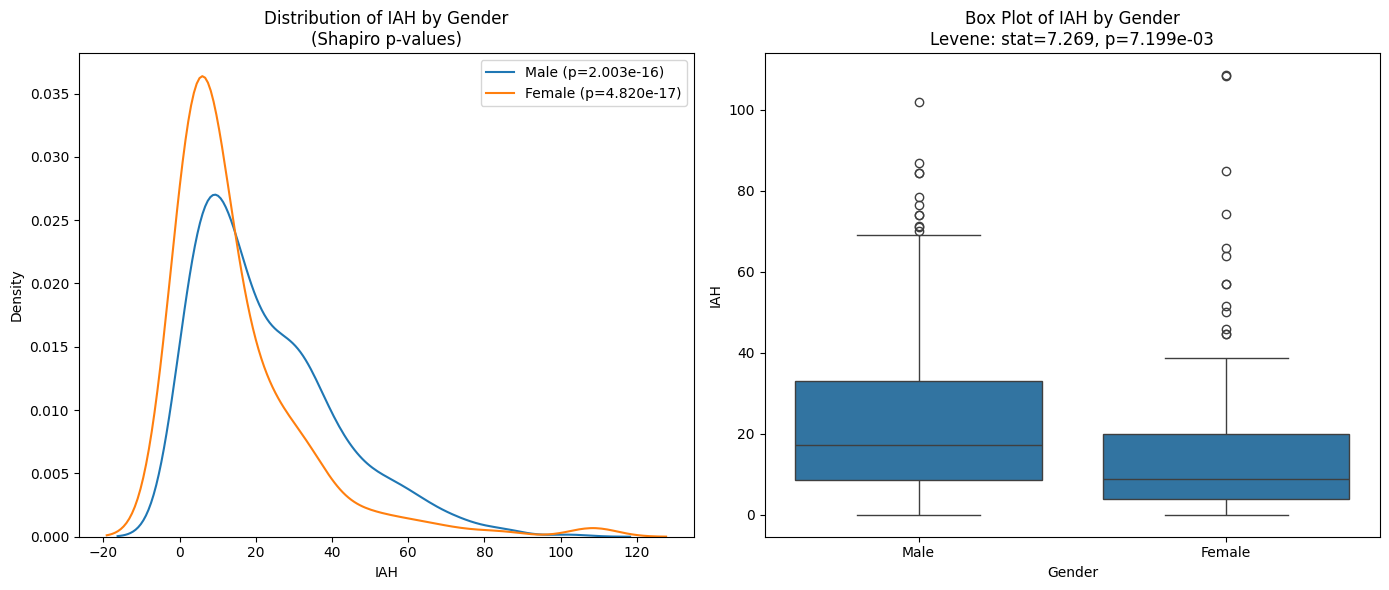


------------------------------------------------------------



In [ ]:


numerical_cols = df_core.select_dtypes(include=['float64']).columns.tolist()
#numerical_cols.remove('IAH')
numerical_cols.remove('Gender')

print("Performing univariate analysis for numerical features (excluding 'IAH'):\n")

for col in numerical_cols:
    print(f"Analyzing column: {col}")

    # =========================
    # Overall distribution plots
    # =========================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(df_core[col], kde=True, ax=axes[0])
    axes[0].set_title(f'Distribution of {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    sns.boxplot(y=df_core[col], ax=axes[1])
    axes[1].set_title(f'Box Plot of {col}')
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    # =========================
    # Descriptive statistics
    # =========================
    print(f"\nDescriptive statistics for '{col}':")
    print(df_core[col].describe())

    # =========================
    # Shapiro tests by Gender
    # =========================
    shapiro_results = {}
    for g in df_core['Gender'].unique():
        data_g = df_core.loc[df_core['Gender'] == g, col].dropna()
        stat, p = shapiro(data_g)
        shapiro_results[g] = (stat, p)

        print(f"\nShapiro–Wilk test for '{col}' | Gender={g}")
        print(f"Statistic = {stat:.4f}, p-value = {p:.4e}")
        if p >= 0.05:
            print("→ Fail to reject H₀: normality assumed.")
        else:
            print("→ Reject H₀: normality NOT assumed.")

    # =========================
    # Levene test by Gender
    # =========================
    groups = [
        df_core.loc[df_core['Gender'] == g, col].dropna()
        for g in df_core['Gender'].unique()
    ]
    stat_lev, p_lev = levene(*groups)

    print("\nLevene test for equality of variances (by Gender):")
    print(f"Statistic = {stat_lev:.4f}, p-value = {p_lev:.4e}")
    if p_lev >= 0.05:
        print("→ Fail to reject H₀: variances CAN be assumed equal.")
    else:
        print("→ Reject H₀: variances CANNOT be assumed equal.")

    # =========================
    # NEW: Gender-based plots
    # =========================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Distribution by gender ---
    for g in df_core['Gender'].unique():
        sns.kdeplot(
            df_core.loc[df_core['Gender'] == g, col].dropna(),
            ax=axes[0],
            label=f"{mapa[g]} (p={shapiro_results[g][1]:.3e})"
        )

    axes[0].set_title(f'Distribution of {col} by Gender\n(Shapiro p-values)')
    axes[0].set_xlabel(col)
    axes[0].legend()

    # --- Boxplot by gender ---
    sns.boxplot(x='Gender_label', y=col, data=df_core, ax=axes[1])
    axes[1].set_title(
        f'Box Plot of {col} by Gender\n'
        f"Levene: stat={stat_lev:.3f}, p={p_lev:.3e}"
    )
    axes[1].set_xlabel('Gender')
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

    print("\n" + "-" * 60 + "\n")


# TESTS

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# Parameters
alpha = 0.05
large_sample_threshold = 30  # threshold to consider CLT robustness
gender_values = df_core['Gender'].unique()

results = []  # to store results for LaTeX table

print("\nGender-based statistical comparison\n" + "="*50)

for col in numerical_cols:
    print(f"\nVariable: {col}")
    print("-" * 50)

    # Split data by gender
    group_data = {
        g: df_core.loc[df_core['Gender'] == g, col].dropna()
        for g in gender_values
    }

    g1, g2 = gender_values
    x = group_data[g1]
    y = group_data[g2]

    # -------------------------
    # Shapiro normality tests
    # -------------------------
    shapiro_p = {}
    for g, data in group_data.items():
        _, p = shapiro(data)
        shapiro_p[g] = p
        print(f"Shapiro–Wilk (Gender={g}): p = {p:.3e}")

    # Determine normality
    normality_flag = {}
    for g in gender_values:
        if shapiro_p[g] >= alpha:
            normality_flag[g] = True
        elif len(group_data[g]) >= large_sample_threshold:
            normality_flag[g] = True  # robust to moderate deviation
        else:
            normality_flag[g] = False

    both_normal = all(normality_flag.values())

    # -------------------------
    # Levene variance test
    # -------------------------
    lev_stat, lev_p = levene(x, y)
    print(f"Levene’s test: p = {lev_p:.3e}")
    equal_var = lev_p >= alpha

    # -------------------------
    # Select statistical test
    # -------------------------
    use_mannwhitney = False
    for g in gender_values:
        if shapiro_p[g] < 0.001:  # extremely non-normal
            use_mannwhitney = True

    if use_mannwhitney:
        test_name = "Mann–Whitney U"
        stat, p_val = mannwhitneyu(x, y, alternative='two-sided')
        print("→ Strong non-normality detected: using Mann–Whitney U")
    else:
        if both_normal:
            if equal_var:
                test_name = "Student’s t-test"
                stat, p_val = ttest_ind(x, y, equal_var=True)
                print("→ Normality and equal variances assumed: Student’s t-test")
            else:
                test_name = "Welch’s t-test"
                stat, p_val = ttest_ind(x, y, equal_var=False)
                print("→ Normality assumed, unequal variances: Welch’s t-test")
        else:
            # moderate non-normality, large samples → Welch's t-test
            test_name = "Welch’s t-test"
            stat, p_val = ttest_ind(x, y, equal_var=False)
            print("→ Moderate non-normality detected: using Welch’s t-test")

    # -------------------------
    # Compute median [Q1–Q3]
    # -------------------------
    def median_iqr(data):
        q1 = np.percentile(data, 25)
        med = np.median(data)
        q3 = np.percentile(data, 75)
        return f"{med:.2f} [{q1:.2f}–{q3:.2f}]"

    median_iqr_F = median_iqr(x)
    median_iqr_M = median_iqr(y)

    # Determine significance
    significant = "Yes" if p_val < alpha else "No"

    # Print final results
    print(f"Selected test: {test_name}")
    print(f"Test statistic = {stat:.4f}")
    print(f"p-value = {p_val:.3e}")
    print(f"Significant difference: {significant}")

    # -------------------------
    # Store for LaTeX table
    # -------------------------
    results.append({
        "Variable": col,
        "Female": median_iqr_F,
        "Male": median_iqr_M,
        "Test": test_name,
        "p-value": f"{p_val:.3e}",
        "Significant": significant
    })

# -------------------------
# Convert results to DataFrame (for LaTeX export)
# -------------------------
results_df = pd.DataFrame(results)
print("\nResults ready for LaTeX export:\n")
print(results_df)



Gender-based statistical comparison

Variable: Age
--------------------------------------------------
Shapiro–Wilk (Gender=0.0): p = 3.297e-05
Shapiro–Wilk (Gender=1.0): p = 6.733e-02
Levene’s test: p = 4.680e-01
→ Strong non-normality detected: using Mann–Whitney U
Selected test: Mann–Whitney U
Test statistic = 37156.5000
p-value = 1.119e-02
Significant difference: Yes

Variable: Weight
--------------------------------------------------
Shapiro–Wilk (Gender=0.0): p = 1.442e-13
Shapiro–Wilk (Gender=1.0): p = 1.311e-07
Levene’s test: p = 5.571e-01
→ Strong non-normality detected: using Mann–Whitney U
Selected test: Mann–Whitney U
Test statistic = 62216.0000
p-value = 5.698e-20
Significant difference: Yes

Variable: Height
--------------------------------------------------
Shapiro–Wilk (Gender=0.0): p = 1.274e-02
Shapiro–Wilk (Gender=1.0): p = 2.084e-01
Levene’s test: p = 1.152e-01
→ Normality and equal variances assumed: Student’s t-test
Selected test: Student’s t-test
Test statistic =

### Distribution of Categorical Variables

We will now visualize the distribution of 'Gender', 'Snoring', and 'Smoker' using bar plots to understand the proportion of each category within these variables.

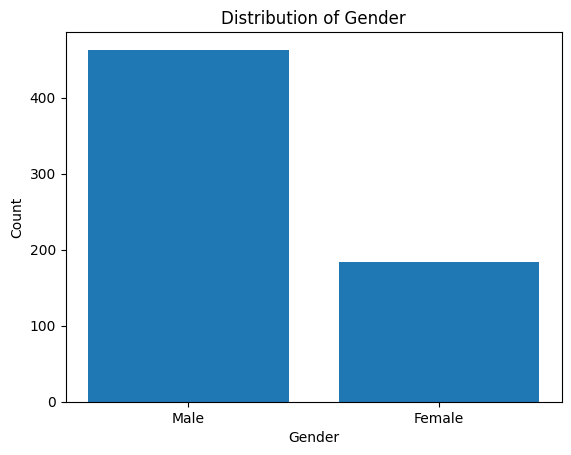

,count
Gender,
0.0,463
1.0,184


In [ ]:
plt.bar(df_extended['Gender'].value_counts().index, df_extended['Gender'].value_counts().values)
xlabels = ['Male', 'Female']
plt.xticks(range(len(xlabels)), xlabels);
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()
display(df_extended['Gender'].value_counts())

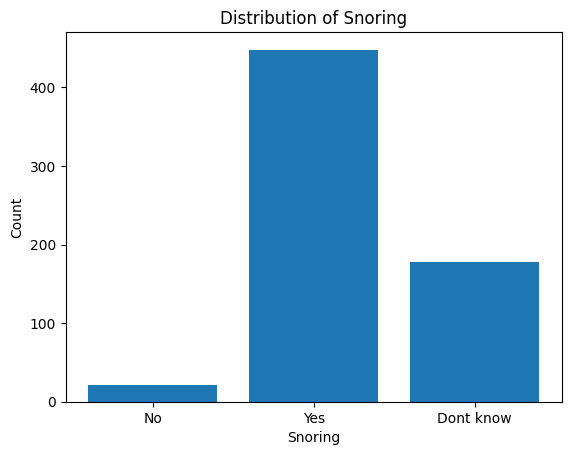

,count
Snoring,
1,448
2,178
0,21


In [ ]:
plt.bar(df_extended['Snoring'].value_counts().index, df_extended['Snoring'].value_counts().values)
xlabels = ['No', 'Yes', 'Dont know']
plt.xticks(range(len(xlabels)), xlabels);
plt.title('Distribution of Snoring')
plt.xlabel('Snoring')
plt.ylabel('Count')
plt.show()
display(df_extended['Snoring'].value_counts())

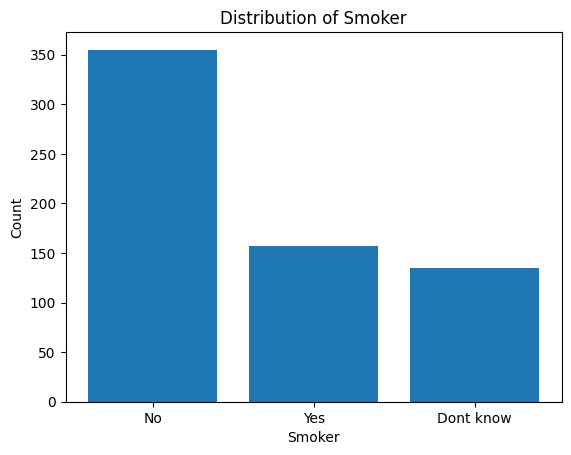

,count
Smoker,
0,355
1,157
2,135


In [ ]:
plt.bar(df_extended['Smoker'].value_counts().index, df_extended['Smoker'].value_counts().values)
xlabels = ['No', 'Yes', 'Dont know']
plt.xticks(range(len(xlabels)), xlabels);
plt.title('Distribution of Smoker')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.show()
display(df_extended['Smoker'].value_counts())

###Bivariate Analysis

In this section relationships between predictor and predictor-target pairs are analyzed with the pearson correlation coefficient and the help of some graphical representations of the pairs like scatter plots.

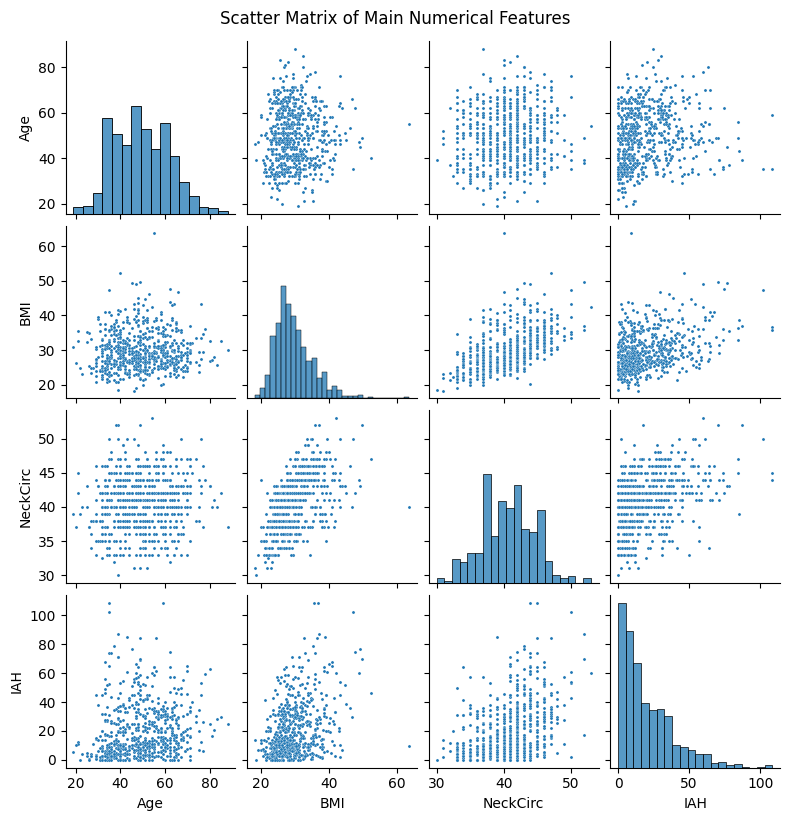

In [ ]:
main_ordered_numerical_cols = ['Age', 'BMI', 'NeckCirc', 'IAH']
sns.pairplot(df_core[main_ordered_numerical_cols], height=2, markers='o', plot_kws={'s': 5})

plt.rcParams['scatter.marker'] = 'o'
plt.rcParams['lines.markersize'] =1.5
plt.suptitle('Scatter Matrix of Main Numerical Features', y=1.02) # Adjust title position
plt.show()



In [ ]:
pval_matrix = pd.DataFrame(index=main_ordered_numerical_cols, columns=main_ordered_numerical_cols, dtype=float)
pval_matrix.head()


,Age,BMI,NeckCirc,IAH
Age,NaN,NaN,NaN,NaN
BMI,NaN,NaN,NaN,NaN
NeckCirc,NaN,NaN,NaN,NaN
IAH,NaN,NaN,NaN,NaN


In [ ]:
for i in main_ordered_numerical_cols:
    for j in main_ordered_numerical_cols:
        r, p = pearsonr(df_core[i], df_core[j])
        pval_matrix.loc[i, j] = p

In [ ]:
pval_matrix.head()


,Age,BMI,NeckCirc,IAH
Age,0.000000,3.214804e-01,3.713979e-02,1.318505e-04
BMI,0.321480,0.000000e+00,9.175046e-49,4.850227e-22
NeckCirc,0.037140,9.175046e-49,0.000000e+00,7.371903e-29
IAH,0.000132,4.850227e-22,7.371903e-29,0.000000e+00


In [ ]:

corr_matrix = df_core[main_ordered_numerical_cols].corr()
annot_matrix_p = corr_matrix.copy().astype(str)
for i in main_ordered_numerical_cols:
    for j in main_ordered_numerical_cols:
        r = corr_matrix.loc[i, j]
        p = pval_matrix.loc[i, j]
        if i == j:
            annot_matrix_p.loc[i, j] = f"{r:.0f}"
        else:
            annot_matrix_p.loc[i, j] = f"{r:.3f}\n(p={p:.2e})"

annot_matrix = corr_matrix.copy().astype(str)
for i in main_ordered_numerical_cols:
    for j in main_ordered_numerical_cols:
        r = corr_matrix.loc[i, j]
        if i == j:
            annot_matrix.loc[i, j] = f"{r:.0f}"
        else:
            annot_matrix.loc[i, j] = f"{r:.3f}"



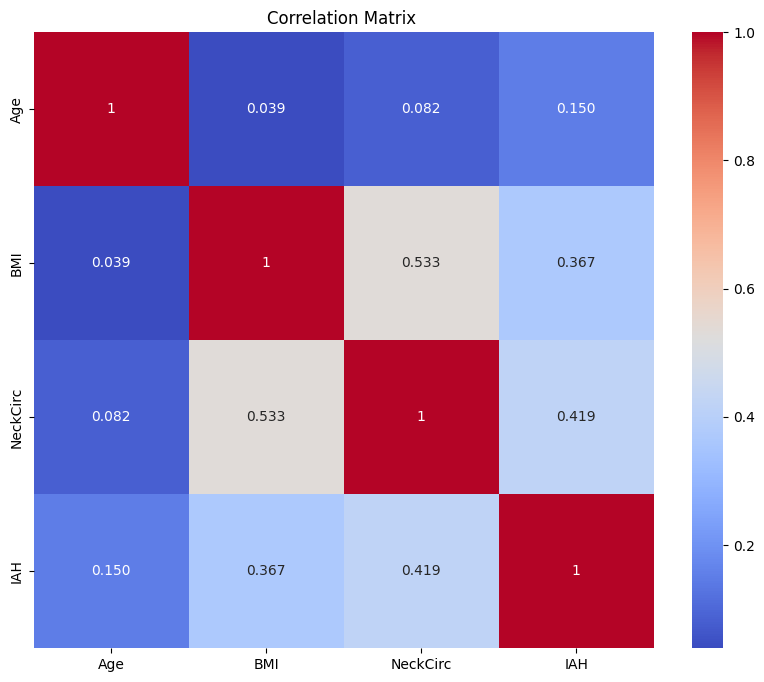

In [ ]:
# ---- Plot heatmap ----
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=annot_matrix,
    fmt="",
    cmap='coolwarm'
)
plt.title("Correlation Matrix ")
plt.show()

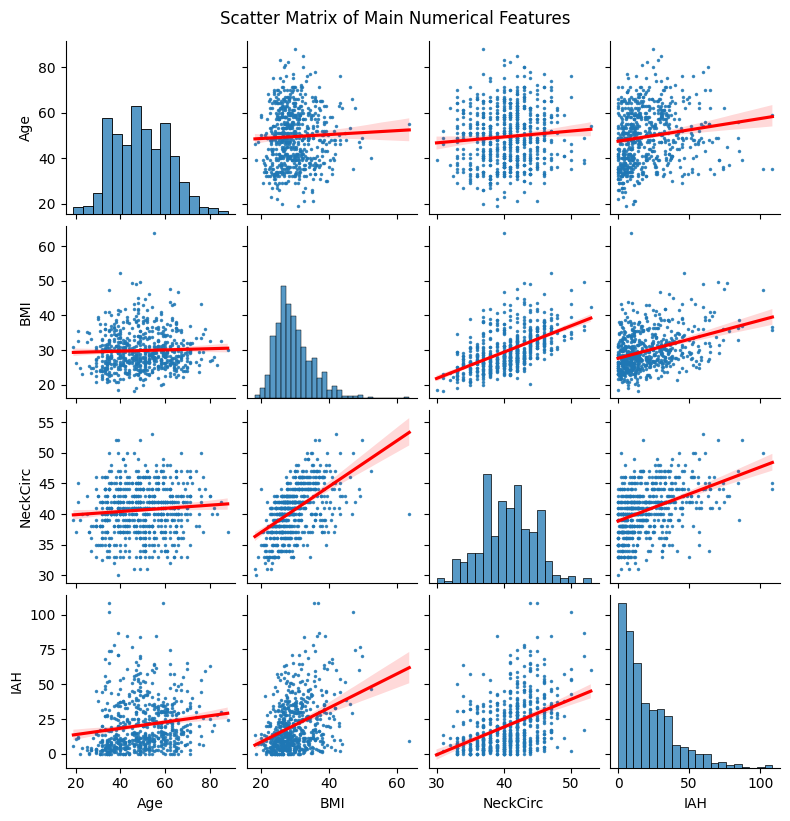

In [ ]:
sns.pairplot(
    df_core[main_ordered_numerical_cols],
    kind='reg',
    height=2,
    markers='o',
    plot_kws={'line_kws': {'color': 'red'}}
)
plt.rcParams['scatter.marker'] = 'o'
plt.rcParams['lines.markersize'] =1.5
plt.suptitle('Scatter Matrix of Main Numerical Features', y=1.02)
plt.show()


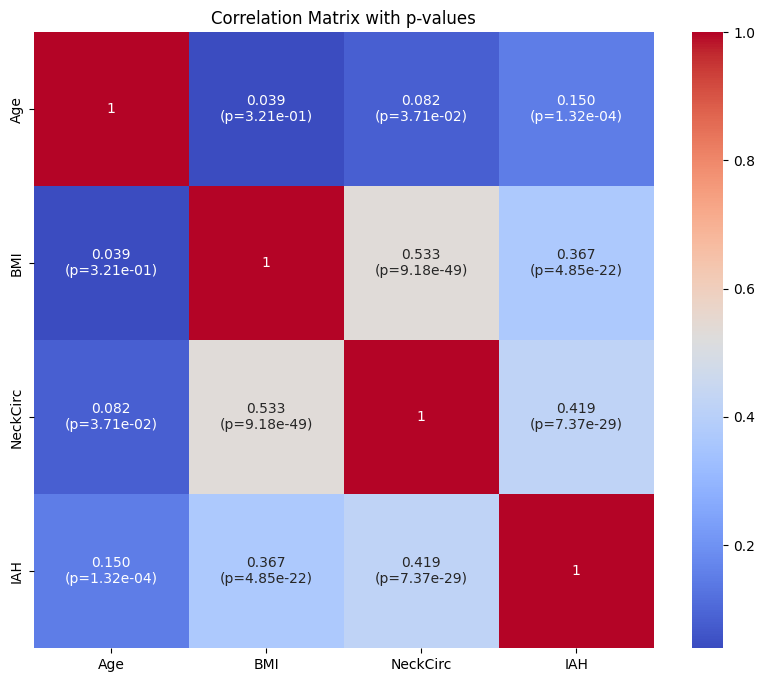

In [ ]:
# ---- Plot heatmap ----
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=annot_matrix_p,
    fmt="",
    cmap='coolwarm'
)
plt.title("Correlation Matrix with p-values")
plt.show()

A preliminary analysis of the main numerical predictors (i.e. excluding the composer variables of BMI) show that both BMI and NeckCirc appear to have som relation with the target variable. On the other hand, Age does not look like to be very related with IAH.

As for the relation ships between predictors, NeckCirc and BMI show a stroong relationship graphically. This might influence the interpretation of the p-values when considering a multlivariate regression.

This next cell has all of the predictor-target variable pairs plotted as scatter plots.

Generating scatter plots for numerical features vs. IAH:


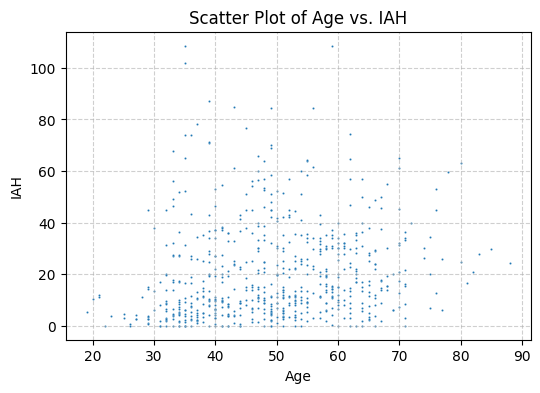


--------------------------------------------------



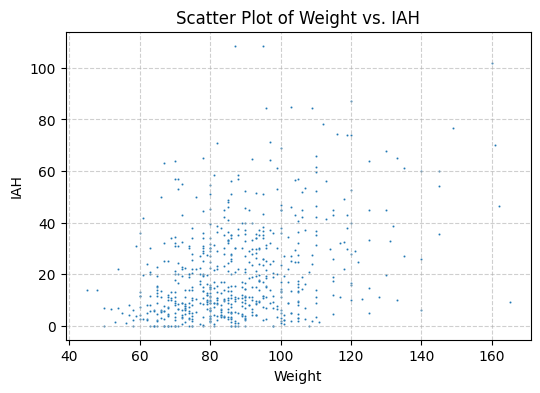


--------------------------------------------------



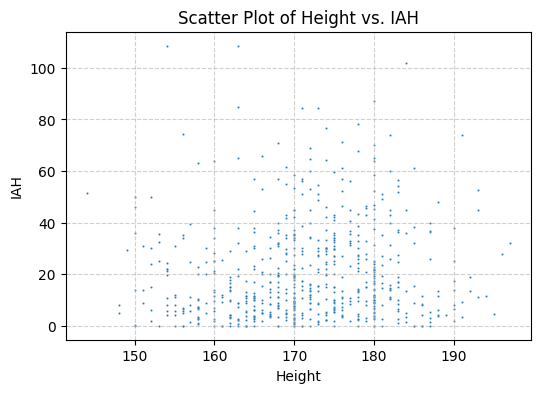


--------------------------------------------------



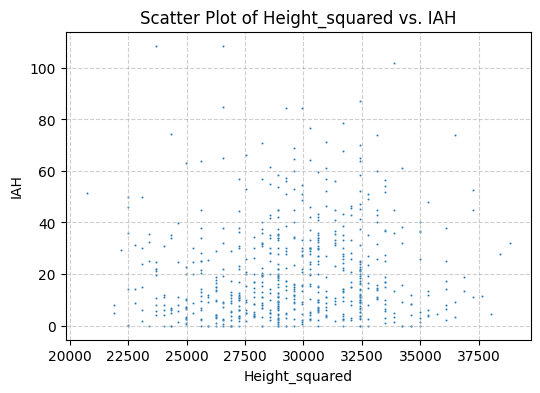


--------------------------------------------------



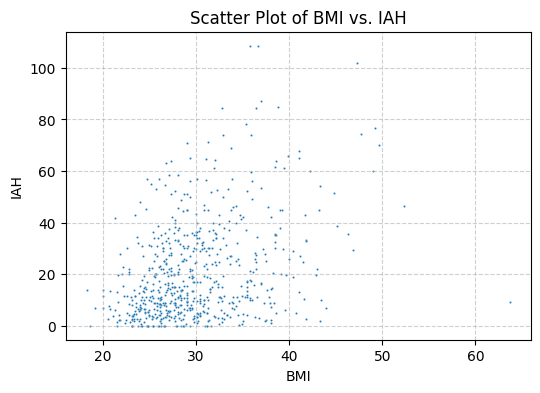


--------------------------------------------------



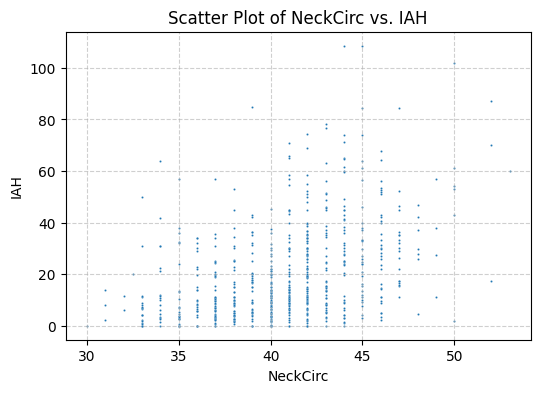


--------------------------------------------------



In [ ]:
numerical_features = ['Age', 'Weight', 'Height', 'Height_squared', 'BMI', 'NeckCirc']

print("Generating scatter plots for numerical features vs. IAH:")

for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_core[feature], y=df_core['IAH'])
    plt.title(f'Scatter Plot of {feature} vs. IAH')
    plt.xlabel(feature)
    plt.ylabel('IAH')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    print("\n" + "-"*50 + "\n")

### Multivariate Analysis

In [ ]:
import statsmodels.api as sm

# Columns to use (excluding Gender)
predictors = ['Age', 'Weight', 'Height', 'Height_squared', 'BMI', 'NeckCirc']
target = 'IAH'

X = df_core[predictors]
y = df_core[target]

# Add intercept
X = sm.add_constant(X)

# Fit Ordinary Least Squares (OLS)
model = sm.OLS(y, X).fit()

# Show regression summary (includes coefficients, standard errors, p-values, R², etc.)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IAH   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     31.83
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           1.42e-33
Time:                        06:57:45   Log-Likelihood:                -2727.5
No. Observations:                 647   AIC:                             5469.
Df Residuals:                     640   BIC:                             5500.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            102.0968    175.396      0.

# Regression

### Data stratification and train–test split


For the regression analysis, the Apnea-Hypopnea Index (AHI) is additionally discretized into clinically meaningful severity groups. Using standard
clinical thresholds, subjects are categorized as Healthy (AHI < 10),
SA (10 ≤ AHI < 30), and Severe OSA (AHI ≥ 30). This grouping allows
exploratory analysis of the distribution of severity levels in the dataset
and facilitates later stratified evaluations.


In [ ]:
# Define AHI thresholds based on standard clinical criteria
bins = [0, 10, 30, float('inf')]
labels = ['Healthy', 'OSA', 'OSA_severe']

# Discretize the continuous AHI variable into severity groups
df_core['IAH_group'] = pd.cut(
    df_core['IAH'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Display the number of subjects in each AHI severity group
df_core['IAH_group'].value_counts()



,count
IAH_group,
Healthy,248
OSA,242
OSA_severe,157


In [ ]:
df_core.head()

,Gender,Age,Weight,Height,Height_squared,BMI,NeckCirc,IAH,Gender_label,IAH_group
0,0.0,39.0,82.0,168.0,28224.0,29.053288,41.0,71.0,Male,OSA_severe
1,0.0,56.0,119.0,174.0,30276.0,39.305060,48.0,29.6,Male,OSA
2,0.0,46.0,86.0,171.0,29241.0,29.410759,43.0,56.0,Male,OSA_severe
3,0.0,39.0,78.0,168.0,28224.0,27.636054,42.0,19.7,Male,OSA
4,0.0,32.0,80.0,173.0,29929.0,26.729927,40.0,9.0,Male,Healthy


To ensure balanced data splits across clinically relevant subpopulations,
a combined stratification variable is constructed using AHI severity group
and biological sex. This variable is intended to preserve both disease
severity distribution and gender proportions during train–test splitting
and cross-validation.


In [ ]:
# Map binary gender encoding to readable labels
df_core['Gender_label'] = df_core['Gender'].map({0: 'Male', 1: 'Female'})

# Create a combined stratification variable based on AHI severity and gender
df_core['stratify_group'] = (
    df_core['IAH_group'].astype(str) + "_" + df_core['Gender_label']
)

# Inspect the distribution of samples across stratification groups
df_core['stratify_group'].value_counts()



,count
stratify_group,
OSA_Male,189
Healthy_Male,145
OSA_severe_Male,129
Healthy_Female,103
OSA_Female,53
OSA_severe_Female,28


The regression model is trained using a subset of clinically relevant demographic and anthropometric variables as predictors, with AHI as the continuous target. The dataset is split into training and test sets using stratification based on the previously defined severity–gender groups, in order to preserve subgroup proportions and mitigate sampling bias.


In [ ]:
# Select predictor variables and define the regression target
X = df_core[['Gender', 'Age', 'BMI', 'NeckCirc']]
y = df_core['IAH']

# Perform stratified train–test split to preserve severity–gender proportions
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=df_core['stratify_group']
)

# Verify that stratification has been preserved in both splits
print("Train proportion:")
print(
    df_core.loc[X_train.index, 'stratify_group']
    .value_counts(normalize=True)
)

print("\nTest proportion:")
print(
    df_core.loc[X_test.index, 'stratify_group']
    .value_counts(normalize=True)
)


Train proportion:
stratify_group
OSA_Male             0.292070
Healthy_Male         0.224371
OSA_severe_Male      0.199226
Healthy_Female       0.158607
OSA_Female           0.081238
OSA_severe_Female    0.044487
Name: proportion, dtype: float64

Test proportion:
stratify_group
OSA_Male             0.292308
Healthy_Male         0.223077
OSA_severe_Male      0.200000
Healthy_Female       0.161538
OSA_Female           0.084615
OSA_severe_Female    0.038462
Name: proportion, dtype: float64


### Stratified cross-validation and model evaluation

Model performance is evaluated using stratified 5-fold cross-validation,
where folds are constructed to preserve the joint distribution of AHI
severity and gender. This strategy allows a robust estimation of regression
performance while accounting for clinically relevant subgroup imbalance.

In [ ]:
# 1. Define predictor variables and continuous regression target
X = df_core[['Gender', 'Age', 'BMI', 'NeckCirc']]
y = df_core['IAH']

# 2. Combined stratification variable (AHI severity category + gender)
strata = df_core['stratify_group']

# 3. Stratified K-Fold cross-validation setup
#    Five folds are used to balance bias and variance in performance estimation
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# 4. Initialize lists to store performance metrics for each fold
r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []

# 5. Manual stratified cross-validation loop
for train_index, test_index in skf.split(X, strata):

    # Split data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Generate predictions on the test fold
    y_pred = model.predict(X_test)

    # Compute and store regression performance metrics
    r2_scores.append(r2_score(y_test, y_pred))

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    rmse_scores.append(np.sqrt(mse))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# 6. Print results as mean ± std
print("R²:    {:.3f} ± {:.3f}".format(np.mean(r2_scores), np.std(r2_scores)))
print("MSE:   {:.3f} ± {:.3f}".format(np.mean(mse_scores), np.std(mse_scores)))
print("RMSE:  {:.3f} ± {:.3f}".format(np.mean(rmse_scores), np.std(rmse_scores)))
print("MAE:   {:.3f} ± {:.3f}".format(np.mean(mae_scores), np.std(mae_scores)))

R²:    0.201 ± 0.064
MSE:   277.220 ± 32.974
RMSE:  16.619 ± 1.013
MAE:   12.577 ± 0.508


### Alternative regression models

These models are evaluated using the same stratified cross-validation
framework in order to compare their performance with the baseline model.

In [ ]:
# 1. Define the alternative regression models to be evaluated
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.01, max_iter=5000),
    'RandomForest': RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
}

# 2. Loop over each regression model
for model_name, model in models.items():

    # Initialize lists to store performance metrics for the current model
    r2_scores = []
    mse_scores = []
    rmse_scores = []
    mae_scores = []

    # 3. Manual stratified cross-validation loop
    for train_index, test_index in skf.split(X, strata):

        # Split data into training and test sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the regression model
        model.fit(X_train, y_train)

        # Generate predictions for the test fold
        y_pred = model.predict(X_test)

        # Compute and store regression performance metrics
        r2_scores.append(r2_score(y_test, y_pred))

        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        rmse_scores.append(np.sqrt(mse))
        mae_scores.append(mean_absolute_error(y_test, y_pred))

    # 4. Report results for the current model as mean ± standard deviation
    print(f"\nModel: {model_name}")
    print("R²:    {:.3f} ± {:.3f}".format(np.mean(r2_scores), np.std(r2_scores)))
    print("MSE:   {:.3f} ± {:.3f}".format(np.mean(mse_scores), np.std(mse_scores)))
    print("RMSE:  {:.3f} ± {:.3f}".format(np.mean(rmse_scores), np.std(rmse_scores)))
    print("MAE:   {:.3f} ± {:.3f}".format(np.mean(mae_scores), np.std(mae_scores)))



Model: Ridge
R²:    0.201 ± 0.064
MSE:   277.197 ± 32.963
RMSE:  16.618 ± 1.013
MAE:   12.576 ± 0.508

Model: Lasso
R²:    0.201 ± 0.064
MSE:   277.184 ± 32.965
RMSE:  16.618 ± 1.013
MAE:   12.576 ± 0.509

Model: RandomForest
R²:    0.163 ± 0.123
MSE:   287.208 ± 27.733
RMSE:  16.927 ± 0.830
MAE:   12.796 ± 0.742


# Classification

### Binary classification: Healthy vs Severe OSA

A binary classification task is defined to distinguish between healthy
subjects and patients with severe obstructive sleep apnea (OSA). Using
clinically established AHI thresholds, intermediate cases are excluded
in order to obtain a clearly separable binary problem and reduce label
ambiguity.


In [ ]:
# Create a copy of the dataset for classification analysis
df_class = df_core.copy()

# Initialize binary OSA target
df_class['OSA_binary'] = None

# Assign class labels based on AHI thresholds
# 0: Healthy (IAH ≤ 10)
# 1: Severe OSA (IAH ≥ 30)
df_class.loc[df_class['IAH'] <= 10, 'OSA_binary'] = 0
df_class.loc[df_class['IAH'] >= 30, 'OSA_binary'] = 1

# Remove intermediate cases (10 < IAH < 30)
df_class = df_class.dropna(subset=['OSA_binary'])

# Ensure integer encoding for classification target
df_class['OSA_binary'] = df_class['OSA_binary'].astype(int)

# Inspect class distribution
df_class['OSA_binary'].value_counts()

,count
OSA_binary,
0,248
1,169


In [ ]:
# Define predictor variables and binary target
features = ['Gender', 'Age', 'BMI', 'NeckCirc']
X = df_class[features]
y = df_class['OSA_binary']

Classification performance is evaluated using stratified 5-fold
cross-validation. Multiple complementary metrics are reported in order
to capture different aspects of classifier behavior, including overall
accuracy as well as the precision–recall trade-off, which is particularly
relevant in the context of severe OSA detection.


In [ ]:
# Stratified 5-fold cross-validation to preserve class proportions
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Initialize lists to store classification metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Manual cross-validation loop to compute multiple metrics
for train_idx, test_idx in skf.split(X, y):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train logistic regression classifier
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Predict class labels on test fold
    y_pred = model.predict(X_test)

    # Store classification performance metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Report cross-validation results as mean ± standard deviation
print("Accuracy:  {:.3f} ± {:.3f}".format(np.mean(accuracy_scores),
                                          np.std(accuracy_scores)))
print("Precision: {:.3f} ± {:.3f}".format(np.mean(precision_scores),
                                          np.std(precision_scores)))
print("Recall:    {:.3f} ± {:.3f}".format(np.mean(recall_scores),
                                          np.std(recall_scores)))
print("F1-score:  {:.3f} ± {:.3f}".format(np.mean(f1_scores),
                                          np.std(f1_scores)))


Accuracy:  0.729 ± 0.050
Precision: 0.703 ± 0.086
Recall:    0.586 ± 0.046
F1-score:  0.638 ± 0.058


### Multiclass classification of OSA severity

A three-class classification task is defined to model OSA severity levels
(healthy, mild/moderate, and severe) using clinically established AHI
thresholds. Unlike the binary setting, intermediate cases are retained,
resulting in a more challenging multiclass problem that better reflects
real-world clinical variability.


In [ ]:
# Create a copy of the dataset for 3-class classification
df_class3 = df_core.copy()

# Initialize 3-class OSA severity target
df_class3['OSA_3class'] = None

# Assign class labels based on AHI severity thresholds
# 0: Healthy (IAH ≤ 10)
# 1: Mild/Moderate OSA (10 < IAH < 30)
# 2: Severe OSA (IAH ≥ 30)
df_class3.loc[df_class3['IAH'] <= 10, 'OSA_3class'] = 0
df_class3.loc[(df_class3['IAH'] > 10) & (df_class3['IAH'] < 30), 'OSA_3class'] = 1
df_class3.loc[df_class3['IAH'] >= 30, 'OSA_3class'] = 2

# Ensure integer encoding for multiclass target
df_class3['OSA_3class'] = df_class3['OSA_3class'].astype(int)

# Inspect class distribution
df_class3['OSA_3class'].value_counts()


,count
OSA_3class,
0,248
1,230
2,169


In [ ]:
# Define predictor variables and multiclass target
X_3 = df_class3[['Gender', 'Age', 'BMI', 'NeckCirc']]
y_3 = df_class3['OSA_3class']

In [ ]:
# Stratified 5-fold cross-validation for multiclass classification
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Initialize lists to store multiclass performance metrics
accuracy_scores = []
f1_scores_macro = []
f1_scores_weighted = []

# Manual cross-validation loop to compute multiclass metrics
for train_idx, test_idx in skf.split(X_3, y_3):

    X_train, X_test = X_3.iloc[train_idx], X_3.iloc[test_idx]
    y_train, y_test = y_3.iloc[train_idx], y_3.iloc[test_idx]

    # Train multinomial logistic regression classifier
    clf = LogisticRegression(
        max_iter=1000,
        multi_class='multinomial'
    )
    clf.fit(X_train, y_train)

    # Predict class labels on test fold
    y_pred = clf.predict(X_test)

    # Store multiclass performance metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores_macro.append(f1_score(y_test, y_pred, average='macro'))
    f1_scores_weighted.append(f1_score(y_test, y_pred, average='weighted'))

# Report cross-validation results as mean ± standard deviation
print("Accuracy:      {:.3f} ± {:.3f}".format(np.mean(accuracy_scores), np.std(accuracy_scores)))
print("F1-macro:      {:.3f} ± {:.3f}".format(np.mean(f1_scores_macro), np.std(f1_scores_macro)))
print("F1-weighted:   {:.3f} ± {:.3f}".format(np.mean(f1_scores_weighted), np.std(f1_scores_weighted)))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

Accuracy:      0.507 ± 0.011
F1-macro:      0.482 ± 0.009
F1-weighted:   0.496 ± 0.008


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### Ablation binary classification

Given that the best predictive performance is obtained in the binary classification setting, subsequent ablation experiments are conducted using this formulation in order to systematically assess the impact of class balancing, regularization strategies, and alternative model choices on classification performance.

In [ ]:
# ============================
# BINARY CLASSIFICATION ABLATION STUDY
# ============================

# Stratified 5-fold cross-validation
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Define models for ablation
models = {
    'Logistic_baseline': LogisticRegression(max_iter=1000),
    'Logistic_balanced': LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ),
    'Logistic_L2': LogisticRegression(
        max_iter=1000,
        penalty='l2',
        C=1.0
    ),
    'Logistic_L1': LogisticRegression(
        max_iter=1000,
        penalty='l1',
        solver='liblinear',
        C=1.0
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
}

# Cross-validation evaluation
for model_name, model in models.items():

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_idx, test_idx in skf.split(X, y):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

    print(f"\nModel: {model_name}")
    print("Accuracy:  {:.3f} ± {:.3f}".format(
        np.mean(accuracy_scores), np.std(accuracy_scores)))
    print("Precision: {:.3f} ± {:.3f}".format(
        np.mean(precision_scores), np.std(precision_scores)))
    print("Recall:    {:.3f} ± {:.3f}".format(
        np.mean(recall_scores), np.std(recall_scores)))
    print("F1-score:  {:.3f} ± {:.3f}".format(
        np.mean(f1_scores), np.std(f1_scores)))



Model: Logistic_baseline
Accuracy:  0.729 ± 0.050
Precision: 0.703 ± 0.086
Recall:    0.586 ± 0.046
F1-score:  0.638 ± 0.058

Model: Logistic_balanced
Accuracy:  0.738 ± 0.051
Precision: 0.656 ± 0.054
Recall:    0.745 ± 0.066
F1-score:  0.698 ± 0.058

Model: Logistic_L2
Accuracy:  0.729 ± 0.050
Precision: 0.703 ± 0.086
Recall:    0.586 ± 0.046
F1-score:  0.638 ± 0.058

Model: Logistic_L1
Accuracy:  0.734 ± 0.053
Precision: 0.711 ± 0.086
Recall:    0.586 ± 0.052
F1-score:  0.642 ± 0.064

Model: RandomForest
Accuracy:  0.724 ± 0.036
Precision: 0.665 ± 0.049
Recall:    0.645 ± 0.045
F1-score:  0.654 ± 0.044


### Extended dataset

After identifying binary classification as the most effective formulation and establishing the balanced logistic regression model as the strongest baseline, an additional ablation experiment is conducted at the dataset level. In this experiment, an extended feature set incorporating symptom-based and behavioral variables is evaluated in order to assess whether these variables provide incremental predictive value beyond the core demographic and anthropometric predictors. The same validation protocol and evaluation metrics are retained to ensure a fair and controlled comparison.

In [ ]:
# ============================
# EXTENDED DATASET (CLEAN) – BINARY CLASSIFICATION
# ============================

# Create binary target
df_ext = df_extended.copy()
df_ext['OSA_binary'] = np.nan

df_ext.loc[df_ext['IAH'] <= 10, 'OSA_binary'] = 0
df_ext.loc[df_ext['IAH'] >= 30, 'OSA_binary'] = 1

df_ext = df_ext.dropna(subset=['OSA_binary'])
df_ext['OSA_binary'] = df_ext['OSA_binary'].astype(int)

# Clean extended feature set (no redundant variables)
features_extended = [
    'Gender',
    'Age',
    'BMI',
    'NeckCirc',
    'Snoring',
    'Smoker'
]

X = df_ext[features_extended]
y = df_ext['OSA_binary']

# Stratified 5-fold cross-validation
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Define models
models = {
    'Logistic_baseline': LogisticRegression(max_iter=1000),
    'Logistic_balanced': LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=100,
        random_state=42
    )
}

# Cross-validation evaluation
for model_name, model in models.items():

    acc, prec, rec, f1 = [], [], [], []

    for train_idx, test_idx in skf.split(X, y):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc.append(accuracy_score(y_test, y_pred))
        prec.append(precision_score(y_test, y_pred))
        rec.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))

    print(f"\nModel: {model_name}")
    print("Accuracy:  {:.3f} ± {:.3f}".format(np.mean(acc), np.std(acc)))
    print("Precision: {:.3f} ± {:.3f}".format(np.mean(prec), np.std(prec)))
    print("Recall:    {:.3f} ± {:.3f}".format(np.mean(rec), np.std(rec)))
    print("F1-score:  {:.3f} ± {:.3f}".format(np.mean(f1), np.std(f1)))


Model: Logistic_baseline
Accuracy:  0.714 ± 0.032
Precision: 0.679 ± 0.053
Recall:    0.568 ± 0.043
F1-score:  0.617 ± 0.038

Model: Logistic_balanced
Accuracy:  0.731 ± 0.042
Precision: 0.646 ± 0.044
Recall:    0.745 ± 0.057
F1-score:  0.692 ± 0.048

Model: RandomForest
Accuracy:  0.734 ± 0.034
Precision: 0.693 ± 0.066
Recall:    0.633 ± 0.052
F1-score:  0.658 ± 0.036
